### Dataset Preprocessing

reading dataset.

This dataset contains (1) 92113 samples of muon w/ 87 features.  (2) label array of 92113 samples  ( 1: true muon, 0: fake muon)

at first, we sample 100 muons for convinience.

In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
import os

os.getcwd( )

'/home/minseok/L3_muon_reconstruction/L3_reconstruction_QNN'

In [4]:
# Read data, no preprocessing
import pandas as pd
import pickle
import numpy as np




import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import r2_score
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Load the .pkl file
with open('./QNN_using_qiskit/DYToLL_PU200_Spring23_NThltIter2FromL1_Barrel.pkl', 'rb') as file:
    data = pickle.load(file)


# Extract the DataFrame and the array from the tuple
df = data[0]  # The first element is the DataFrame : 92113 sample rows × 87 feature columns
array = data[1]  # The second element is the NumPy array : true labels for the 92113 samples

# Display the DataFrame
print(df)

# If you need to work with the array, you can do so separately
print(array)

# Slicing the data
# Randomly select 300 indices from the DataFrame for convinience
np.random.seed(0)
random_indices = np.random.choice(df.index, size=300, replace=False)

# Select the corresponding rows from the DataFrame
df_sampled = df.loc[random_indices]

# Select the corresponding labels from the array
array_sampled = array[random_indices]

# Display the sampled DataFrame and array
print(df_sampled)
print(array_sampled)

# Save the sampled data to an Excel file
# df_sampled.to_excel("./sampled_data.xlsx")

# Convert the sampled data to tensors
input_X = torch.tensor(df_sampled.values, dtype=torch.float32)
label_y = torch.tensor(array_sampled, dtype=torch.float32)

print(input_X)
print(label_y)

print(input_X.size())
print(label_y.size())

           mva0  truePU  dir   tsos_detId     tsos_pt  tsos_pt_val  tsos_eta  \
0      6.318764   200.0  1.0  305217556.0   39.650185    39.650185  0.329402   
1      6.487538   200.0  1.0  306221072.0   36.018456    36.018456 -0.400440   
2      9.632208   200.0  1.0  306282500.0    6.234634     6.234634 -0.931489   
3      5.693322   200.0  1.0  306290708.0   16.508461    16.508461 -0.405084   
4      6.053555   200.0  1.0  306249748.0  103.609093   103.609093 -0.328105   
...         ...     ...  ...          ...         ...          ...       ...   
92109  4.712126   200.0  1.0  306221076.0   24.187933    24.187933 -0.207863   
92110  5.961148   200.0  1.0  305205272.0   24.159716    24.159716  0.044301   
92111  6.035942   200.0  1.0  305139736.0   74.839699    74.839699  0.407732   
92112  4.046599   200.0  1.0  306241556.0   20.078423    20.078423 -0.118347   
92113  3.463670   200.0  1.0  305156116.0    4.497806     4.497806  0.385827   

       tsos_phi  tsos_glob_x  tsos_glob

In [5]:
# Read the data and preprocess it
import sys
import os

# Assuming your project structure as above, add the parent directory to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), "./L3_reconstruction_QNN"))


if project_root not in sys.path:
    sys.path.append(project_root)

# Now you should be able to import from BDT_model
from BDT_model.HLTIO import preprocess

import pandas as pd
import pickle

# Path to the original pickle file
pkl_path = "./QNN_using_qiskit/DYToLL_PU200_Spring23_NThltIter2FromL1_Barrel.pkl"


# Load the pickle file
with open(pkl_path, "rb") as file:
    data = pickle.load(file)

# Assume the first element of the tuple is the original DataFrame
df = data[0]

# Apply setClassLabel to compute the class labels
df = preprocess.setClassLabel(df)

# Compute the distance features (expd2hitl1tk1,..,expd2hitl1tk4)
# We use addAbsDist=False as in the readSeedTree flow to drop the d2hitl1tk variables.
df = preprocess.addDistHitL1Tk(df, addAbsDist=False)

# Define the list of required columns:
required_columns = [
    "expd2hitl1tk1",
    "expd2hitl1tk2",
    "expd2hitl1tk3",
    "dR_L1TkMuSeedP",
    "dPhi_L1TkMuSeedP",
    "tsos_qbp",
    "tsos_dydz",
    "tsos_dxdz",
    "tsos_err0",
    "tsos_err2",
    "tsos_err5",
    "y_label"  # class label from setClassLabel
]

# Check whether all required columns are present; if not, issue a warning.
missing = [col for col in required_columns if col not in df.columns]
if missing:
    print("Warning: The following required columns are missing:", missing)

# Create a new DataFrame with only the required columns.
df_final = df[required_columns].copy()

# Display the first few rows of the final DataFrame
print(df_final.head())

# Optionally, save the resulting DataFrame to an Excel file.
# df_final.to_excel("processed_data.xlsx", index=False)
### Data sampling and excluding nan value
from IPython.display import display

# Exclude the samples with NaN values
df_final = df_final.dropna().copy()


# sampling 100 samples from the final DataFrame ( 100 samples w/ 11 features + 1 label)
df_final_sample = df_final.sample(n=100, replace=False, random_state=42).copy()


label_data = df_final_sample.iloc[:, -1] # extract y_label from the last column
input_data = df_final_sample.iloc[:, :-1] # extract X from the first 11 columns

X = torch.tensor(input_data.values, dtype=torch.float32)
y = torch.tensor(label_data.values, dtype=torch.float32)

split = int(0.8 * len(X))  # 80% train, 20% test
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Move the data to the device ( GPU or CPU )
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')


   expd2hitl1tk1  expd2hitl1tk2  expd2hitl1tk3  dR_L1TkMuSeedP  \
0       0.990987       0.713180       0.987402        0.004175   
1       0.689316       0.764362       0.674484        0.005500   
2       0.548451       0.480737       0.999237        0.027850   
3       0.767553       0.994757       0.998245        0.008985   
4       0.741779       0.999612       0.997960        0.001913   

   dPhi_L1TkMuSeedP  tsos_qbp  tsos_dydz  tsos_dxdz  tsos_err0     tsos_err2  \
0         -0.003510 -0.023912  -0.335638  -0.038410   0.000043  6.029049e-08   
1          0.004065  0.025677  -0.411500   0.036356   0.000068  6.829735e-08   
2         -0.027783 -0.109400   1.075664   0.080918   0.000016  1.170655e-07   
3         -0.008914 -0.055924   0.417587   0.080094   0.000023  6.257859e-08   
4          0.001653  0.009154   0.334038  -0.009316   0.000005  2.613838e-08   

      tsos_err5  y_label  
0  1.060757e-07      1.0  
1  7.030542e-08      1.0  
2  2.279720e-07      1.0  
3  7.708970e-0

### Building Qunantum Circuit

Based on this dataset, build quantum circuit of 11 qubit

In [12]:
# import libraries

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

# qiskit
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import ParameterVector, Parameter
from qiskit.quantum_info import SparsePauliOp


# qiskit qml related
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

# qiskit pennylane plugin
import pennylane as qml
from pennylane import numpy as pnp
import jax
from jax import numpy as jnp
import optax
from pennylane.optimize import NesterovMomentumOptimizer, AdamOptimizer
import jax.random as jrandom

# Define the quantum device : statevector simulator
dev = qml.device('default.qubit', wires=11)




In [23]:
# Define the quantum circuit

n_wires = 11
n_layers = 1


# jax : Using JAX tensors for automatic differentiation
@qml.qnode(dev, interface = "jax")
def QNN(inputs, weights_qaoa, weights_entan, bias):

    
   
    # data embedding
    for i in range(n_layers):
        qml.templates.QAOAEmbedding(inputs, wires=range(n_wires), weights=weights_qaoa[i])

    # entangling layer
    for i in range(n_layers):
        qml.templates.StronglyEntanglingLayers(weights_entan[i], wires=range(n_wires))
    
    # measurement with PauliZ string; expectation val of summaiton of PauliZ operators
    return qml.expval(qml.sum(*[qml.PauliZ(i) for i in range(n_wires)])) + bias




In [24]:
# Define the loss function with jit

@jax.jit
def huber_loss_fn(y_true, data, params , delta=1.0):
    """
    Compute the Huber loss for quantum predictions using JAX NumPy.

    Parameters:
    - y_true: True values (scalar or array).
    - y_pred: Predicted values (scalar or array).
    - delta: Threshold for switching between quadratic and linear loss.

    Returns:
    - Huber loss value.
    """
    y_pred = QNN(data, params["weights_qaoa"], params["weights_entan"], params["bias"])

    error = y_true - y_pred
    abs_error = jnp.abs(error)

    quadratic = 0.5 * error ** 2  # MSE region
    linear = delta * (abs_error - 0.5 * delta)  # MAE region

    loss = jnp.where(abs_error <= delta, quadratic, linear)

    return loss



In [ ]:
# Initialization of the weights

key = jrandom.PRNGKey(42)  # Set a random seed for reproducibility

# create n_layers x n_wires random weights 
weights_qaoa = jrandom.uniform(key, (n_layers, n_wires), minval=0, maxval=2 * jnp.pi)
weights_entan = jrandom.uniform(key, (n_layers, n_wires), minval=0, maxval=2 * jnp.pi)
bias = jnp.array(0.)


In [ ]:


params = {"weights_qaoa": weights_qaoa, "weights_entan": weights_entan, "bias": bias}

# Test the loss function
y_true = 1.0
data = X_train[0]
loss = huber_loss_fn(y_true, data, params)
print(f"Initial loss: {loss:.4f}")

from qiskit.primitives import StatevectorEstimator as Estimator, StatevectorSampler as Sampler  # simulator
from qiskit_aer.primitives import EstimatorV2, SamplerV2


estimator_aer = EstimatorV2()
sampler_aer = SamplerV2()

estimator = Estimator()
sampler = Sampler()


# parity maps bitstrings to 0 or 1 ( depending on the parity of the number of '1' in bitstring)
def parity(x):
    return "{:b}".format(x).count("1") % 2

output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.



# create a QNN instance with simulator.
estimator_qnn = EstimatorQNN(
    circuit=ansatz,
    estimator = estimator_aer,
    input_gradients=True,
    input_params = ansatz.parameters[:11],  # input data embedding parameters : the first 11 parameters
    weight_params = ansatz.parameters[11:]  # trainable parameters : the rest of the parameters
)

# create a QNN instance with sampler.
sampler_qnn = SamplerQNN(
    circuit=ansatz,
    sampler = sampler_aer,
    interpret = parity,
    output_shape=output_shape,
    input_gradients=True,
    input_params = ansatz.parameters[:11],  # input data embedding parameters : the first 11 parameters
    weight_params = ansatz.parameters[11:]  # trainable parameters : the rest of the parameters
)



torch.Size([80, 11])

In [12]:
np.random.seed(0)
initial_weights = 0.1*(2* np.random.rand(99) -1 )
estimator_qnn.forward(X_train.cpu(), initial_weights )

array([[0.22606924],
       [0.35344338],
       [0.49075145],
       [0.84550082],
       [0.39180472],
       [0.89553806],
       [0.97915324],
       [0.50642205],
       [0.6695479 ],
       [0.96080366],
       [0.38215593],
       [0.61830745],
       [0.43005256],
       [0.64275014],
       [0.9780673 ],
       [0.45036435],
       [0.32861368],
       [0.96077134],
       [0.37463973],
       [0.4399256 ],
       [0.70938542],
       [0.98596904],
       [0.960947  ],
       [0.93197414],
       [0.38907883],
       [0.65288814],
       [0.73219925],
       [0.95318986],
       [0.78404619],
       [0.38999317],
       [0.91446842],
       [0.60236816],
       [0.48803079],
       [0.50067351],
       [0.41897287],
       [0.36263137],
       [0.39136749],
       [0.45654889],
       [0.87238957],
       [0.61966931],
       [0.41630792],
       [0.4034891 ],
       [0.38838511],
       [0.42649093],
       [0.43348495],
       [0.3966509 ],
       [0.23129405],
       [0.435

### Using TorchConnector to make hybrid-quantum

In [13]:
# Create TorchConnector model

np.random.seed(0)
initial_weights = 0.1*(2* np.random.rand(99) -1 )


# create TorchConnector instance ( connects torch to qiskit )
qnn_estimator = TorchConnector(estimator_qnn, initial_weights=initial_weights).to(device)
qnn_sampler = TorchConnector(sampler_qnn, initial_weights=initial_weights).to(device)

qnn = qnn_estimator

# create a Custom QNN model.
# For future reference, you can build hybrid model that combine classical MLP and quantum circuit.
class MyQNN4L3Muon(nn.Module):
    def __init__(self):
        super().__init__()
        self.qnn = qnn

    def forward(self,x):
        return self.qnn(x)


model1 = MyQNN4L3Muon().to(device)

# test the model
print(f"Test the model w/ initial weights and 1st sample : {model1(X_train).size()}")


Test the model w/ initial weights and 1st sample : torch.Size([80, 1])


In [ ]:
print(device)

cuda


In [14]:
# define optimizer, scheduler, and loss function
optimizer = optim.Adam(model1.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# good balance between MAE and MSE
loss_function = nn.HuberLoss(delta=0.1)

epochs = 100
batch_size = 10

# for tracking purpose
train_losses = []
test_losses = []
r2_score_value = []   # r2 = how well the model predicts the data

for epoch in range(epochs):

    # set the model to train mode; ensures gradients are computed
    # ensures dropout layers are active
    model1.train()

    # shuffle the data
    permutation = torch.randperm(len(X_train))
    running_loss = 0.0

    for i in range(0, len(X_train), batch_size):  # loop over mini-batch per one epoch
        print(f"{epoch} epoch has been proceeding,  {i}th batch roop has been proceeding")
        indices = permutation[i:i+batch_size]  # 0-9th permuted indices, 10-19, 20-29, ... when batch_size=10
        X_batch, y_batch = X_train[indices], y_train[indices]  # get the mini-batch data

        print(f"X_batch = {X_batch.size()}, y_batch = {y_batch.size()}")

        # zero the parameter gradients : in default setting, the gradients from previous epoch are accumulated
        optimizer.zero_grad()

        # forward pass
        y_pred_estimator = model1(X_batch).squeeze()
        y_pred_sampler   = model1(X_batch)[:,0]   # choose 1st column as output class of sampler.

        # designate which primitives will be used
        y_pred = y_pred_estimator

        if y_pred.size() != y_batch.size():
            print(f"y_pred size: {y_pred.size()}, y_batch size: {y_batch.size()}")
            raise ValueError("y_pred and y_batch have different sizes")


        loss = loss_function(y_pred.to(device), y_batch.to(device))  # compute the loss

        loss.backward()  # backward pass for computing the gradients

        optimizer.step()  # update the weights
        running_loss += loss.item()  # accumulate the loss

    avg_train_loss = running_loss / ( len(X_train) / batch_size)
    train_losses.append(avg_train_loss)


    # set the model to evaluation mode; ensures gradients are not computed
    # ensures dropout layers are inactive
    model1.eval()
    with torch.no_grad(): # no need to compute the gradients
        y_test_pred = model1(X_test).squeeze()
        test_loss = loss_function(y_test_pred, y_test)
        test_losses.append(test_loss.item())

    scheduler.step(test_loss)

    # convert the final prediction ( number between -1 and 1 ) to numpy array
    y_pred_final = y_test_pred.cpu().numpy()
    y_test_final = y_test.cpu().numpy()

    # compute the r2 score
    r2 = r2_score(y_test_final, y_pred_final)
    r2_score_value.append(r2)


    # print log
    print(f"\nEpoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {avg_train_loss:.4f}, Test Loss: {test_loss:.4f}")
    print(f"R2 Score: {r2:.4f}")

    for name, param in model1.named_parameters():
        print(f"{name} - Mean: {param.mean().item():.4f}, Std: {param.std().item():.4f}")

#############################################################################################################
# Training is done.


0 epoch has been proceeding,  0th batch roop has been proceeding
X_batch = torch.Size([10, 11]), y_batch = torch.Size([10])
0 epoch has been proceeding,  10th batch roop has been proceeding
X_batch = torch.Size([10, 11]), y_batch = torch.Size([10])
0 epoch has been proceeding,  20th batch roop has been proceeding
X_batch = torch.Size([10, 11]), y_batch = torch.Size([10])
0 epoch has been proceeding,  30th batch roop has been proceeding
X_batch = torch.Size([10, 11]), y_batch = torch.Size([10])
0 epoch has been proceeding,  40th batch roop has been proceeding
X_batch = torch.Size([10, 11]), y_batch = torch.Size([10])
0 epoch has been proceeding,  50th batch roop has been proceeding
X_batch = torch.Size([10, 11]), y_batch = torch.Size([10])
0 epoch has been proceeding,  60th batch roop has been proceeding
X_batch = torch.Size([10, 11]), y_batch = torch.Size([10])
0 epoch has been proceeding,  70th batch roop has been proceeding
X_batch = torch.Size([10, 11]), y_batch = torch.Size([10])



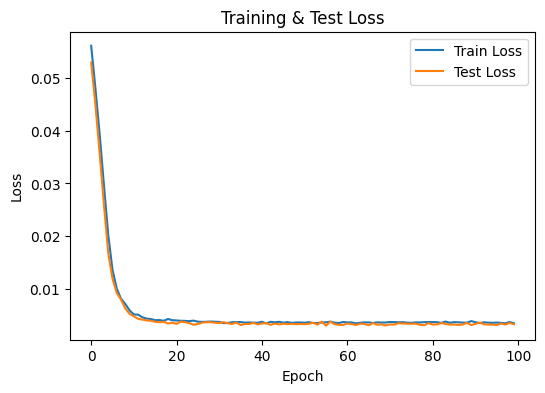

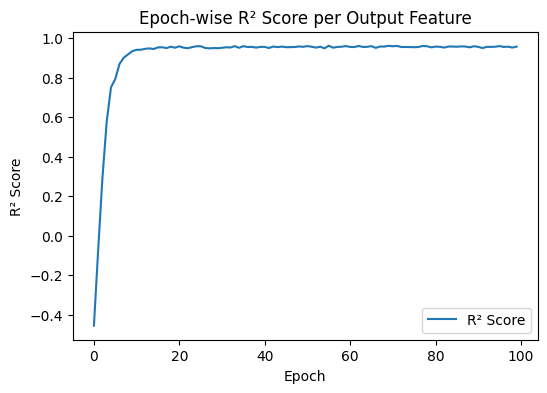

/tmp/ipykernel_170995/318767961.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.text(i, y_pred_final[i] + 0.05, f'{float(y_pred_final[i]):.2f}', ha='center', fontsize=12)


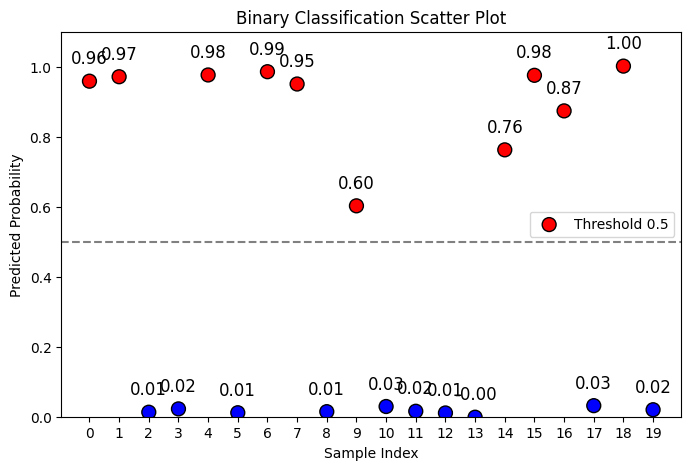

In [33]:
# plot the loss and r2 score
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Test Loss")
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(r2_score_value, label="R² Score")
plt.xlabel("Epoch")
plt.ylabel("R² Score")
plt.title("Epoch-wise R² Score per Output Feature")
plt.legend()
plt.show()

# After training, evaluate the model on the test data
with torch.no_grad():
    y_pred_final = model1(X_test).cpu().numpy()
    y_test_np = y_test.cpu().numpy()

plt.figure(figsize=(8, 5))
plt.scatter(range(len(y_test_np)), y_pred_final, c=y_test_np, cmap='bwr', edgecolors='black', s=100)
plt.axhline(y=0.5, color='gray', linestyle='--', label='Threshold = 0.5')

for i in range(len(y_test_np)):
    plt.text(i, y_pred_final[i] + 0.05, f'{float(y_pred_final[i]):.2f}', ha='center', fontsize=12)

plt.xticks(range(len(y_test_np)))
plt.xlabel("Sample Index")
plt.ylabel("Predicted Probability")
plt.title("Binary Classification Scatter Plot")
plt.legend(["Threshold 0.5"])
plt.ylim(0, 1.1)

plt.show()

### *Notice about choosing loss function for Quantum Classificaiton

In classical machine learning, the general rule of thumb is to apply a Cross-Entropy loss to classification tasks, and MSE loss to regression tasks. However, this recommendation is given under the assumption that the output of the classification network is a class probability value in the range (usually this is achieved through a Softmax layer). Because the following example for EstimatorQNN does not include such layer, and we don’t apply any mapping to the output (the following section shows an example of application of parity mapping with SamplerQNNs), the QNN’s output can take any value in the range . In case you were wondering, this is the reason why this particular example uses MSELoss for classification despite it not being the norm (but we encourage you to experiment with different loss functions and see how they can impact training results).